### Import data

In [1]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames

# Import data
data = CSV.read("..//data//DOX.csv")
total = CSV.read("..//data//DOX_pop.csv")

# delete the extra index column which strats at 0 
deletecols!(data, :Column1)
deletecols!(total, :Column1)

# get the number of data points
len = length(data[:,1])
time = data[:,1]

# just to make sure all have the same size
total_old = total[:,9];
G2_old = data[:,9];

# rescaling the experimental data assuming we have 20 initial cells for each trial
init_cells = 20.0
total_new = init_cells * total_old
G2_new = 0.01*total_new.*G2_old;
G1_new = total_new .- G2_new;
g2_0 = init_cells*(G2_old[1]/100.0)
g1_0 = init_cells*(1- (G2_old[1]/100.0))

plot(G1_new, label = "G1")
plot!(G2_new, label = "G2")
plot!(total_new, label = "total")
print(g1_0, "\n", g2_0)

# param_holder_lap_dde = zeros(7,9);
# param_holder_lap_ode = zeros(4,9);

16.97273966379
3.02726033621

### ODE solve

In [ ]:
function ODEmodel(du, u, p, t)

    du[1] = -p[1]*u[1] + 2*p[2]*u[2] - p[3]*u[1]
    du[2] = p[1]*u[1] - p[2]*u[2] - p[4]*u[2]
end

function ODEsolve(par)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = ODEProblem(ODEmodel, u0, tspan, par)
    solve(prob, Tsit5())
end

function residuals(par)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = ODEsolve(par)
    res[2, :] = sol(t, idxs = 1).u - G1_new
    res[1, :] = sol(t, idxs = 2).u - G2_new
    return res
end

p = [8.870525323648254,8.492087168644503,0.4344732303091874,7.678477905020965]
t = LinRange(0.0, 95.5, 192)
low = [0.0, 0.0, 0.0, 0.01]

# result_ode = optimize(residuals, p, Dogleg(), lower = low)
result_ode = optimize(residuals, p, LevenbergMarquardt(), lower = low; iterations = 10^8)

In [ ]:
params = result_ode.minimizer
param_holder_lap_ode = CSV.read("params_lap_ODE.csv")
param_holder_lap_ode[:, 7] = params
CSV.write("params_lap_ODE.csv", DataFrame(param_holder_lap_ode))


# param_holder_gem_ode[:, 1] = ["alpha", "beta", "gamma1", "gamma2"]
# CSV.write("params_gem_ODE.csv", DataFrame(param_holder_gem_ode))

# params =  [0.129992538367695,0.04567232337751,0.017989068250636, 0.0601300854109052327189]

# sol = DDEsolve(params)
t = LinRange(0.0, 95.5, 192)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")


t_new = LinRange(0.0, 195.5, 292)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = ODEProblem(ODEmodel, u0_new, tspan_new, params)
solution = solve(prob_new, Tsit5())

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Lap. Trial 7 ODE", legend=:topleft, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
savefig("lap_7_ode_long.png")

In [ ]:
# param_holder_lap_ode[:, 1] = ["alpha", "beta", "gamma1", "gamma2"]
# CSV.write("params_lap_ODE.csv", DataFrame(param_holder_lap_ode))

### Using Dogleg()/ LevenbergMarquardt() for optimization DDE

In [3]:
# This model doesn't assume delay for dying
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)

    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end

function resid(pp)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = DDEsolve(pp)
    res[1, :] = sol(t, idxs=1).u - G1_new
    res[2, :] = sol(t, idxs=2).u - G2_new
    return res
end

# We could just find the best guess for the first trial and then just substitude the previous estimated parameter 
# to find the next trial as our initial guess (mostl of the time works well!)
p = [0.003023320921113364,0.0014400198961915481,21.54871791162119,24.208217034754412,354.60780814248744,0.0113691115869946,0.04740242785413226]

# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = [0.0001, 0.0001, 0.45, 2.0, 0.0001, 0.0001, 0.0001]
# results_dde = optimize(resid, p, Dogleg(), lower = low)
results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [0.0027649580142314763,0.0015864740375326157,15.80713095519228,15.233596840618008,335.57700790486456,0.027453459915657646,0.04700402850958006]
 * Sum of squares at Minimum: 2834.323979
 * Iterations: 47
 * Convergence: true
 * |x - x'| < 1.0e-08: false
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
 * |g(x)| < 1.0e-08: false
 * Function Calls: 48
 * Gradient Calls: 30
 * Multiplication Calls: 141


### Solve and Plot for Dogleg() optimization

[0.00276496, 0.00158647, 15.8071, 15.2336, 335.577, 0.0274535, 0.047004]

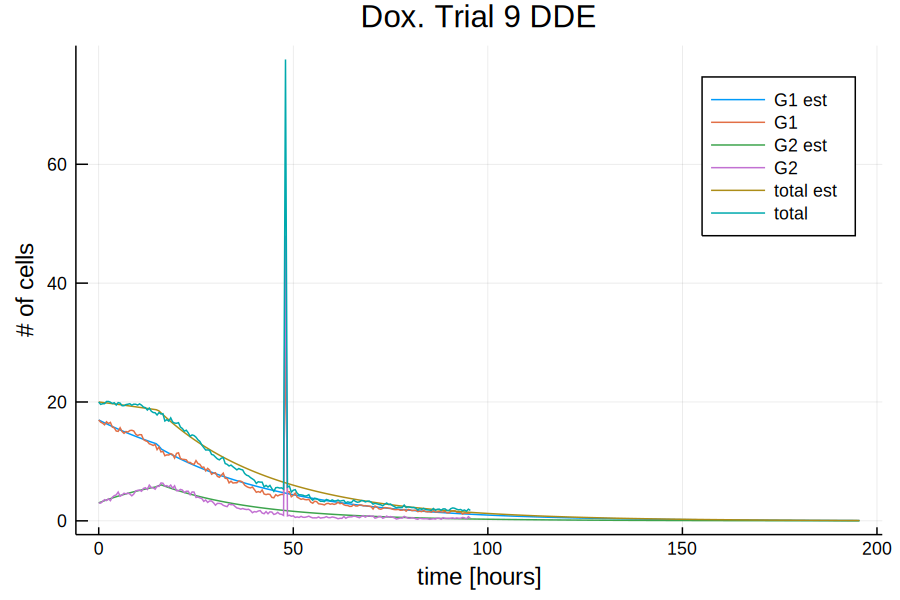

In [4]:
params = results_dde.minimizer
print(params)
# param_holder_dox_dde = CSV.read("params_dox_DDE.csv")
# param_holder_dox_dde[1:7, 4] = params 
# CSV.write("params_dox_DDE.csv",  DataFrame(param_holder_dox_dde))


# param_holder_dox_dde[:, 1] = ["alpha", "beta", "tau1", "tau2", "history", "gamma1", "gamma2"]
# CSV.write("params_lap_DDE.csv",  DataFrame(param_holder_lap_dde))
# a function to find the percent of G2/G1


# params = [0.006758559730374953,0.03908346228494832,33.415954991720604,12.671989080584897,7.33434043361262,0.001,0.050347773002366731]

# [0.0907053578132587,0.0814318178369392, 5.3165035986640648,13.50624238256753,12.617320332544436,0.05271183196084762,0.0642927236871003]
# sol = DDEsolve(params)
t = LinRange(0.0, 95.5, 192)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")

lags = [params[3], params[4]]
t_new = LinRange(0.0, 195.5, 292)
h(p, t_new) = params[5]*ones(2)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = DDEProblem(DDEmodel, u0_new, h, tspan_new, params; constant_lags = lags)
solution = solve(prob_new, MethodOfSteps(Tsit5()))

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Dox. Trial 9 DDE", legend=:topright, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
# savefig("dox_9_dde_long.png")

In [ ]:
# param_holder_lap_dde[:, 1] = ["alpha", "beta", "tau1", "tau2", "history", "gamma1", "gamma2"]
# CSV.write("params_lap_DDE.csv",  DataFrame(param_holder_lap_dde))

### To plot parameters against drug concentrations

In [10]:
using Plots, CSV;

param_lap_dde = CSV.read(".//figures//Lapatinib//dde//params_lap_DDE.csv")
param_gem_dde = CSV.read(".//figures//Gem//dde//params_gem_DDE.csv")
param_dox_dde = CSV.read(".//figures//Dox//dde//params_dox_DDE.csv")
param_taxol1_dde = CSV.read(".//figures//taxol//dde//params_taxol1_DDE.csv")
lap = convert(Matrix, param_lap_dde[:,3:end])
gem = convert(Matrix, param_gem_dde[:,3:end])
dox = convert(Matrix, param_dox_dde[:,3:end])
tax = convert(Matrix, param_taxol1_dde[:,3:end])

function plot_param_conc(lap, gem, dox, tax, i, param)
    p1 = plot(lap[8, :], lap[i, :], label = "Lapatinib", title = param, xlabel = "drug conc. [nM]", ylabel = "param")
    p2 = plot(gem[8, :], gem[i, :], label = "Gemcitabine", xlabel = "drug conc. [nM]", ylabel = "param")
    p3 = plot(dox[8, :], dox[i, :], label = "Doxorubicin", xlabel = "drug conc. [nM]", ylabel = "param")
    p4 = plot(tax[8, :], tax[i, :], label = "Paclitaxel", xlabel = "drug conc. [nM]", ylabel = "param")
    plot(p1, p2, p3, p4, dpi = 100)
end

plot_param_conc(lap, gem, dox, tax, 1, "alpha")
# savefig()

MethodError: MethodError: no method matching round(::Int64, ::Float64)
Closest candidates are:
  round(!Matched::Type{T<:Integer}, ::AbstractFloat) where T<:Integer at float.jl:361
  round(!Matched::Type{T<:Integer}, ::AbstractFloat, !Matched::RoundingMode{:ToZero}) where T<:Integer at floatfuncs.jl:123
  round(!Matched::Type{T<:Integer}, ::AbstractFloat, !Matched::RoundingMode) where T<:Integer at floatfuncs.jl:124
  ...